In [6]:
%matplotlib inline

from wikicrawl.crawlers import WikiCrawler
from datetime import datetime
import networkx as nx
#import pywikibot
from wikicrawl.tools.divtools import get_cosine
import matplotlib.pyplot as plt

start_date = datetime(2006, 1, 1)
crawler = WikiCrawler()

crawler.crawl_time_series(page_title="Andrey Markov",  
                          time_series_interval='yearly',
                          crawl_type='heuristic',
                          timestamp=start_date,
                    div_from_root=True,
                    div_func=lambda x, y: 1 - get_cosine(x, y),
                    node_count=1, debug=False)

VERBOSE:pywiki:Found 1 wikipedia:pms processes running, including this one.
VERBOSE:pywiki:Found 1 wikipedia:en processes running, including this one.


In [2]:
from collections import defaultdict, Counter

class SortedKeyDict(dict):
    """A dictionary that applies an arbitrary key-altering
       function before accessing the keys"""

    def __init__(self, *args, **kwargs):
        dict.__init__(self, *args, **kwargs)
    
    def __getitem__(self, key):
        return super(SortedKeyDict, self).__getitem__(self.__keytransform__(key))

    def __setitem__(self, key, value):
        super(SortedKeyDict, self).__setitem__(self.__keytransform__(key), value)

    def __delitem__(self, key):
        super(SortedKeyDict, self).__delitem__(self.__keytransform__(key))

    def __keytransform__(self, key):
        try:
            return tuple(sorted(key))
        except (TypeError):
            return key
        
class SortedKeyCounter(Counter):
    """A dictionary that applies an arbitrary key-altering
       function before accessing the keys"""

    def __init__(self, *args, **kwargs):
        Counter.__init__(self, *args, **kwargs)
    
    def __getitem__(self, key):
        return super(SortedKeyCounter, self).__getitem__(self.__keytransform__(key))

    def __setitem__(self, key, value):
        super(SortedKeyCounter, self).__setitem__(self.__keytransform__(key), value)

    def __delitem__(self, key):
        super(SortedKeyCounter, self).__delitem__(self.__keytransform__(key))

    def __keytransform__(self, key):
        try:
            return tuple(sorted(key))
        except (TypeError):
            return key
        
class SortedKeyDefaultDict(defaultdict):
    """A dictionary that applies an arbitrary key-altering
       function before accessing the keys"""

    def __init__(self, *args, **kwargs):
        defaultdict.__init__(self, *args, **kwargs)
    
    def __getitem__(self, key):
        return super(SortedKeyDefaultDict, self).__getitem__(self.__keytransform__(key))

    def __setitem__(self, key, value):
        super(SortedKeyDefaultDict, self).__setitem__(self.__keytransform__(key), value)

    def __delitem__(self, key):
        super(SortedKeyDefaultDict, self).__delitem__(self.__keytransform__(key))

    def __keytransform__(self, key):
        try:
            return tuple(sorted(key))
        except (TypeError):
            return key    

def draw_graph_with_edge_attrs(subg, attrs=['div'], figsize=(8,8)):
    from collections import defaultdict
    
    plt.figure(figsize=figsize, facecolor="w", frameon=False)

    edge_labels = defaultdict(list)
    
    for attr in attrs:
        for edge, attr_val in nx.get_edge_attributes(subg,'div').items():
            try:
                edge_labels[edge].append(round(float(attr_val), 3))
            except ValueError:
                edge_labels[edge].append(attr_val)

    pos = nx.spring_layout(subg)
    nx.draw(subg, pos, with_labels=True, node_size=200)
    nx.draw_networkx_edge_labels(subg, pos, font_color='g', edge_labels=edge_labels)
    
def div_diff(g1, g2, debug=False):
    diffs = SortedKeyDict()
    for node in g2:
        for neighbor in g2[node]:
            if node in g1 and neighbor in g1[node]:
                diff = g2[node][neighbor]['div']-g1[node][neighbor]['div']
                diff = round(diff, 4)

                if debug:
                    if diff > 0:
                        print("{0} and {1} repelled".format(node, neighbor))
                    else:
                        print("{0} and {1} attracted".format(node, neighbor))

                    print("{0} difference in divergence from 2003 to 2004".format(diff))
                    print()
                    
                diffs[(node, neighbor)] = diff
                #yield([(node, neighbor), diff])
    return diffs

def nodes_in_cliques_of_graph(g, min_clq_size=3):
    clqs = [clq for clq in nx.find_cliques(g) if len(clq) >= min_clq_size]
    return set([node for clq in clqs for node in clq])


import matplotlib.pyplot as plt
import numpy as np

#fig, ax = plt.subplots()
def draw_node_to_neighbor_divs(g, node_name, neighbor_lim=None, title=None, fig_size=(10, 5)):
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(1,1,1)
    if title:
        fig.suptitle(title, fontsize=14)
    
    vals = sorted(list(g[node_name].items()), 
                  key=lambda x: x[1]['div'] if 'div' in x[1] else 1.0)
    
    if neighbor_lim:
        vals = vals[:neighbor_lim]

    x = [x for x,y in  vals if 'div' in y]
    x_locs = np.arange(len(x))*2
    y = [y['div'] for _, y in vals if 'div' in y]

    bars = ax.bar(x_locs, y, width=.5)

    #plt.margins(0.1)
    fig.autofmt_xdate()
    plt.xticks(x_locs, x, rotation='vertical')


    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., 1.05*height, float(round(height, 3)),
                    ha='center', va='bottom', rotation=90)

    ax.set_ylim(top=1.1)

    autolabel(bars)

    plt.show()
    
def draw_top_k_average_div_per_year(graphs, node_name, k=5, fig_size=(10, 5)):
    print(node_name)
    fig = plt.figure(figsize=fig_size)
    
    fig.suptitle(node_name, fontsize=14)#, fontweight='bold')
    
    ax = fig.add_subplot(1,1,1)
    
    ax.set_title("Avg. '1-cosine similarity' of top-5 most similar 'forward Wiki-links'")
    
    width = .35
    
    x = []
    y = []
    y2 = []
    
    for g in graphs:
        
        divs = sorted(list(g[node_name].items()), 
                  key=lambda x: x[1]['div'] if 'div' in x[1] else 1.0)[:k]
        
        divs = [y['div'] if 'div' in y else 1 for _, y in divs]
        
        x.append(g.graph['year'])
        y.append(np.average(divs))
        
        y2.append(len(g[node_name]))
        
    #print(x)
    #print(y)
    ax2 = ax.twinx()
    
    x_locs = np.arange(len(x))*2

    bars = ax.bar(x_locs, y, width=width, color='b')
    bars2 = ax2.bar(x_locs+width, y2, width=width, color='g')

    plt.xticks(x_locs, x, rotation='vertical')

    fig.autofmt_xdate()

    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., 1.05*height, float(round(height, 3)),
                    ha='center', va='bottom')#, rotation=90)

    #ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))

    ax.set_ylim(top=1.1)
    ax2.set_ylim(0, max(y2)+1)
    print(max(y2))
    autolabel(bars)
    #autolabel(bars2)
    
    node_name = node_name.replace('.', '')
    plt.savefig(node_name)

    plt.show()

Andrey Markov
54


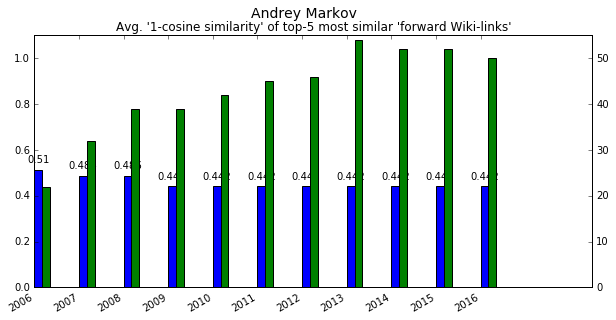

In [7]:
for g in crawler.graphs:
    g.graph['year'] = g.graph['starting_date'].year
    
draw_top_k_average_div_per_year(crawler.graphs, 'Andrey Markov')